In [135]:
from pandas import read_csv, unique

import numpy as np

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [136]:
file = open('WISDM_ar_v1.1_raw.csv')
lines = file.readlines()
processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [137]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [138]:
import pandas as pd
data = pd.DataFrame(data = processedList, columns = columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [139]:
data.duplicated(subset=None, keep='first').sum()

36712

In [140]:
data.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)

In [141]:
data.duplicated(subset=None, keep='first').sum()

0

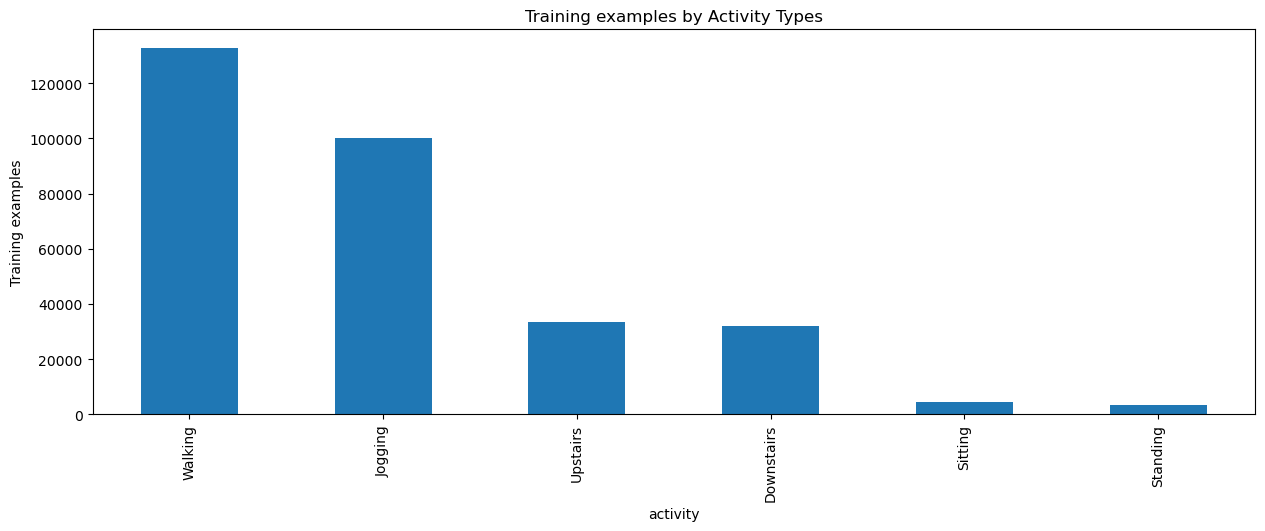

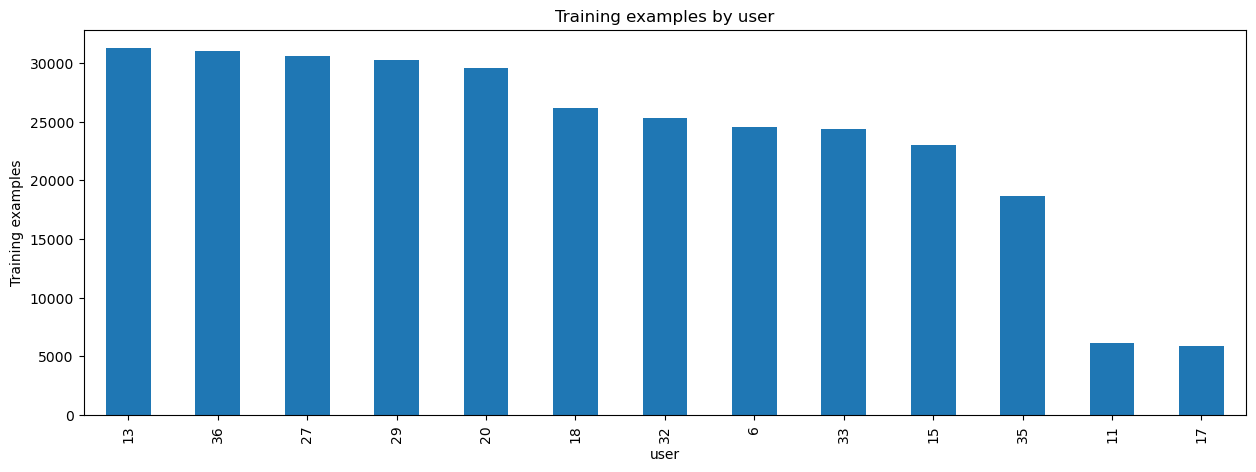

In [142]:
plt.figure(figsize=(15, 5))

plt.xlabel('Activity Type')
plt.ylabel('Training examples')
data['activity'].value_counts().plot(kind='bar',
                                  title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
data['user'].value_counts().plot(kind='bar', 
                                 title='Training examples by user')
plt.show()

In [143]:

data['activity'].value_counts()


activity
Walking       132871
Jogging       100285
Upstairs       33511
Downstairs     32192
Sitting         4372
Standing        3473
Name: count, dtype: int64

In [144]:
# Data Balance
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

In [145]:
Fs = 20
activities = data['activity'].value_counts().index

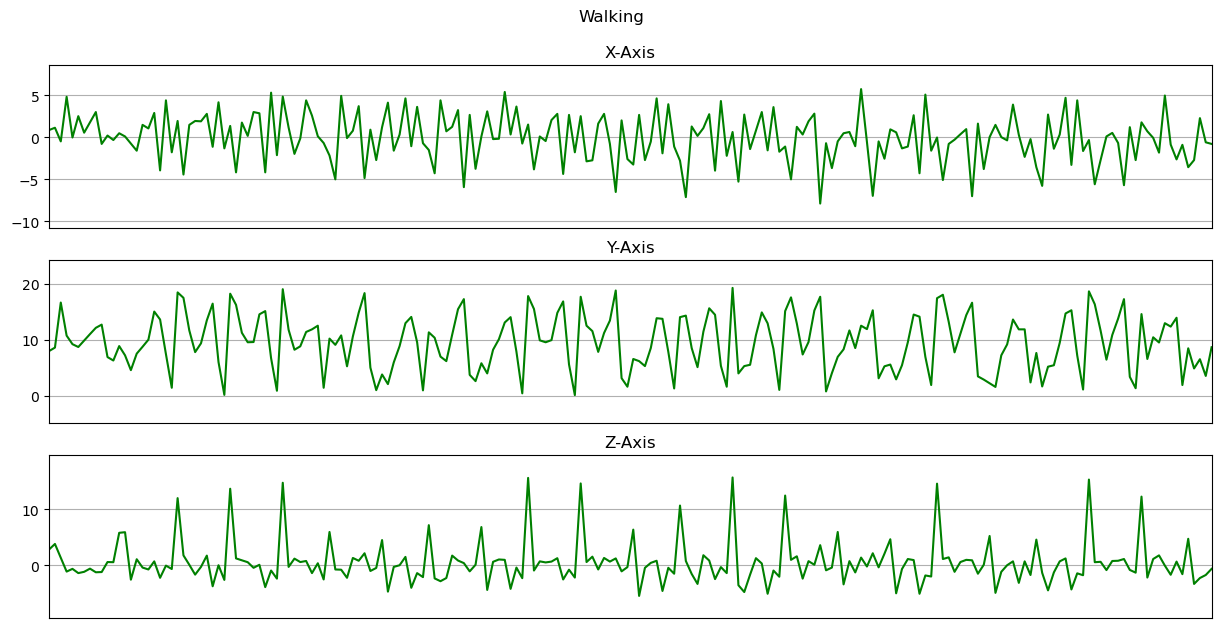

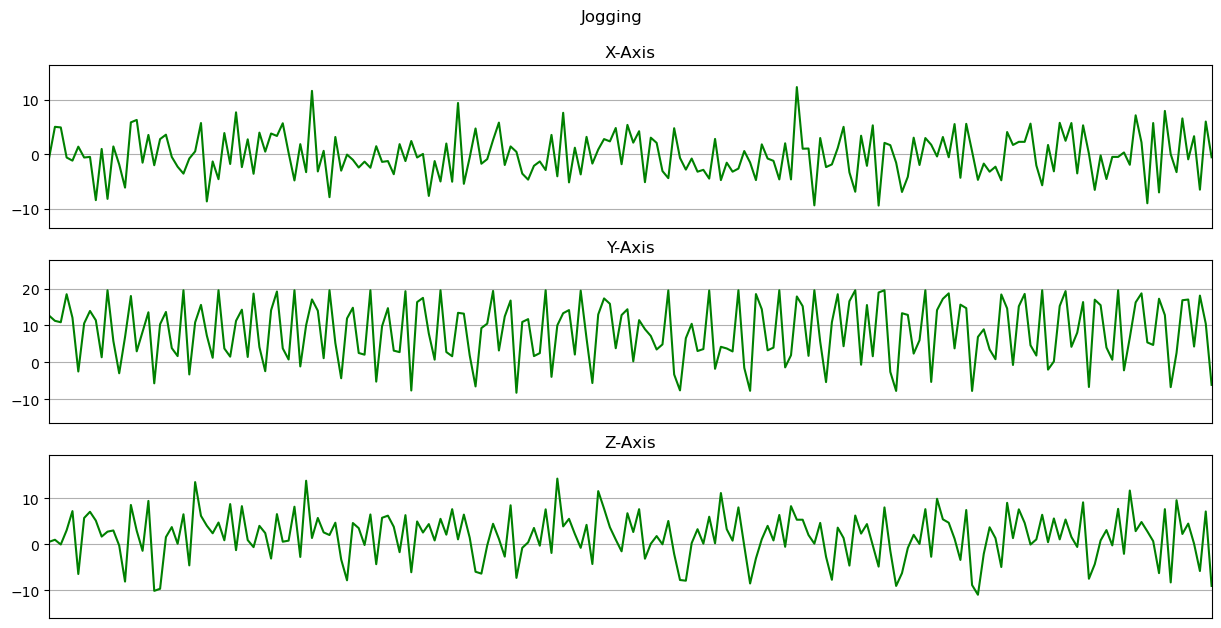

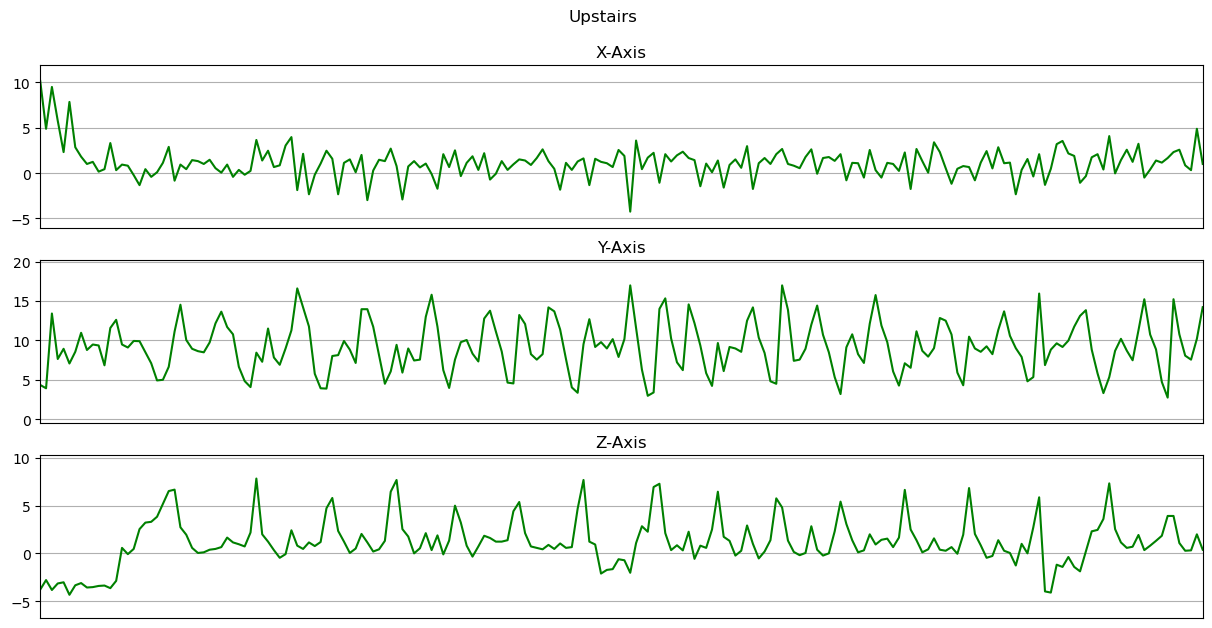

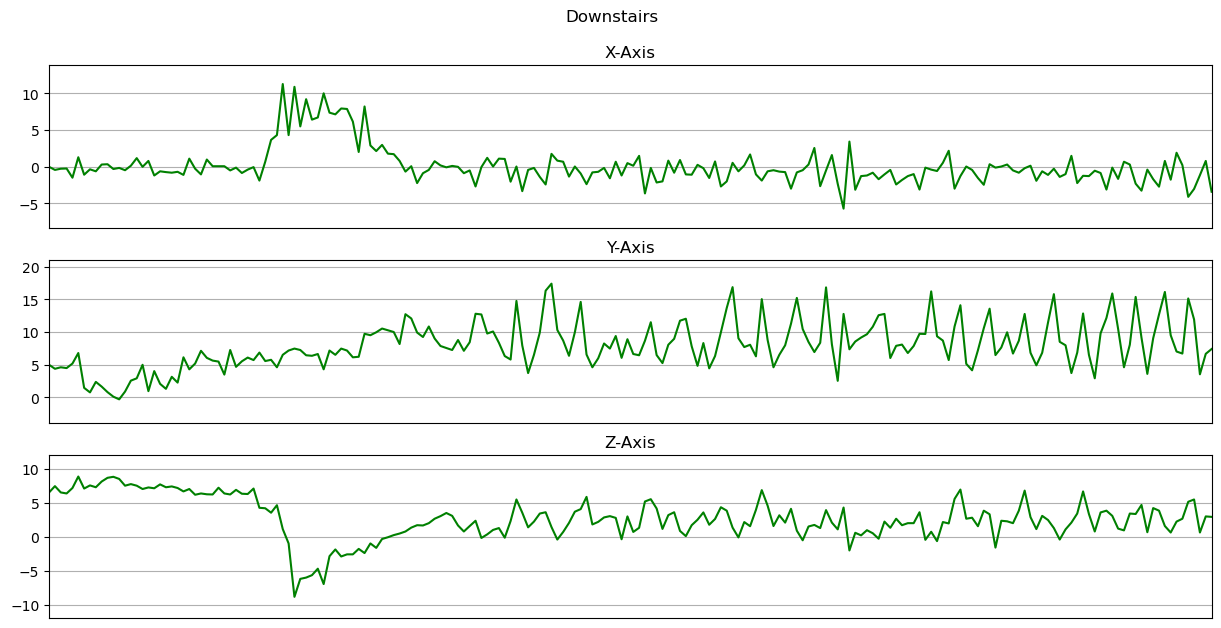

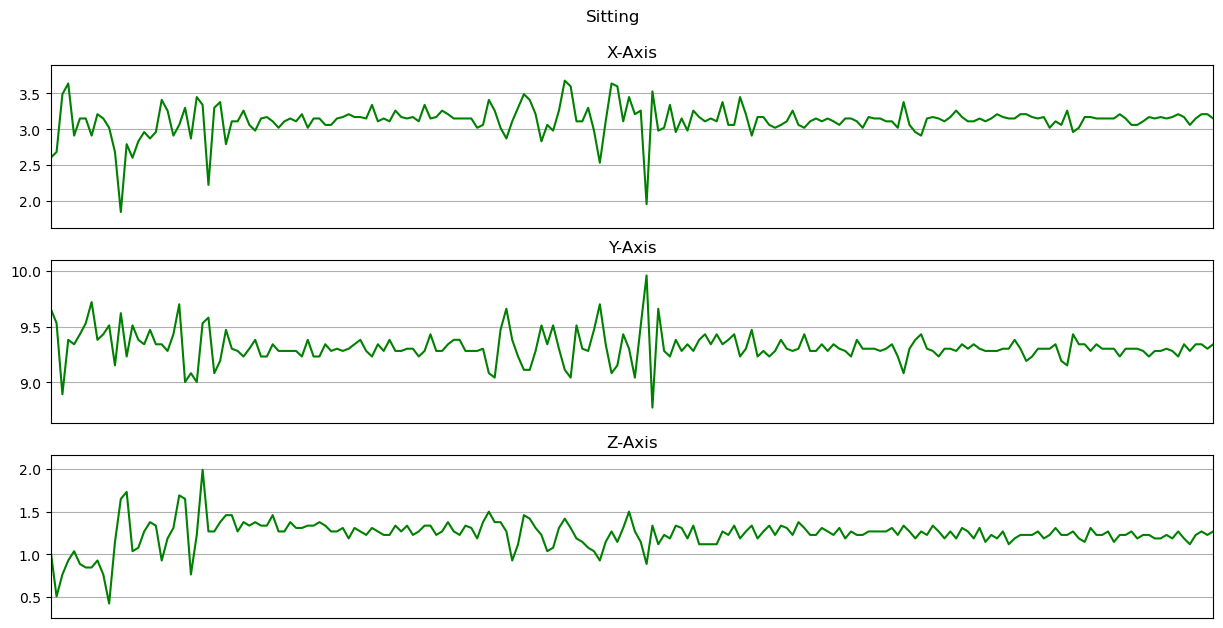

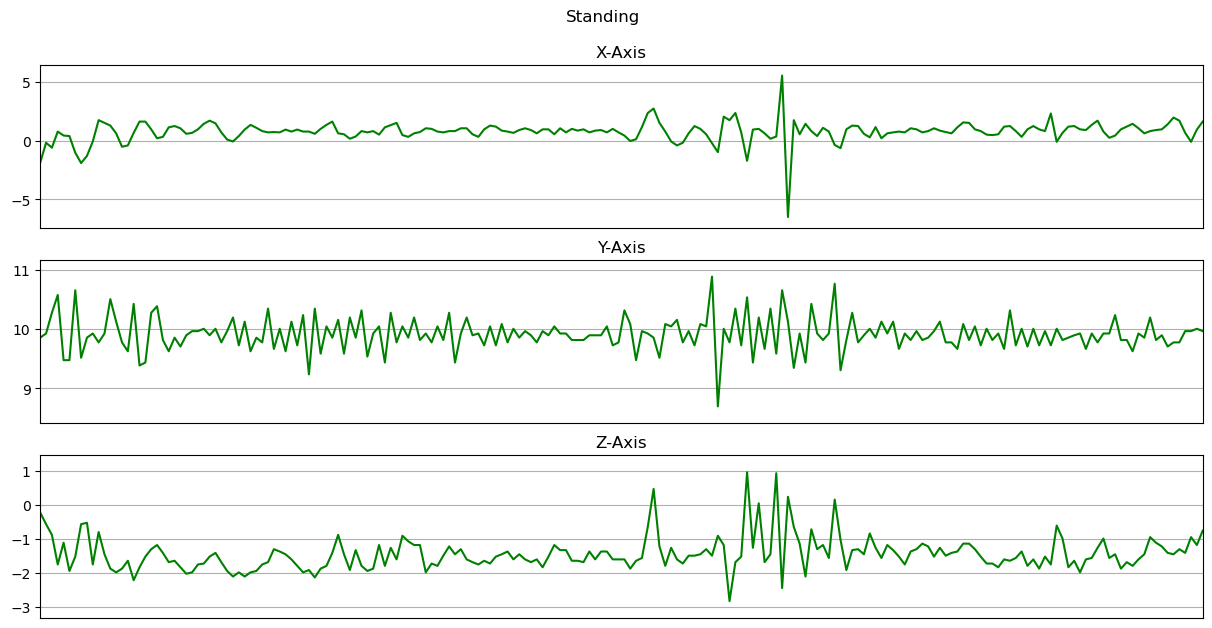

In [146]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [147]:
df = data.drop(['user', 'time'], axis = 1).copy()
df.head()
     

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [148]:
Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].copy()

In [149]:
import pandas as pd

# Assuming Walking, Jogging, Upstairs, Downstairs, Sitting, and Standing are your DataFrames
# Replace these with your actual DataFrames

# Create an empty DataFrame (optional, for clarity)
balanced_data = pd.DataFrame()

# Concatenate the DataFrames
balanced_data = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing], ignore_index=True)

# Display the shape of the concatenated DataFrame
print(balanced_data.shape)


(21248, 4)


In [150]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
0,Walking,0.844462,8.008764,2.792171,5
1,Walking,1.116869,8.621680,3.786457,5
2,Walking,-0.503953,16.657684,1.307553,5
3,Walking,4.794363,10.760075,-1.184970,5
4,Walking,-0.040861,9.234595,-0.694638,5


In [151]:
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

In [152]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,0.003170,-0.091778,0.330627,5
1,0.076060,0.026904,0.624114,5
2,-0.357636,1.582961,-0.107595,5
3,1.060074,0.440974,-0.843324,5
4,-0.233723,0.145587,-0.698590,5
...,...,...,...,...
21243,-0.466285,0.183424,0.254239,3
21244,-0.538531,0.198915,0.242178,3
21245,-0.624155,0.202787,0.254239,3
21246,-0.776674,0.055624,0.149710,3


In [153]:
import scipy.stats as stats

In [154]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [155]:
import numpy as np

def get_frames(df, frame_size, hop_size):
    frames = []
    labels = []

    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        # Use numpy.bincount to get the mode (most common element) in the segment
        label_counts = np.bincount(df['label'].values[i: i + frame_size])
        
        # Find the label with the maximum count
        label = np.argmax(label_counts)

        frames.append([x, y, z])
        labels.append(label)

    return np.array(frames), np.array(labels)

In [156]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [157]:
X.shape, y.shape

((530, 3, 80), (530,))

In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [159]:
X_train.shape, X_test.shape

((424, 3, 80), (106, 3, 80))

In [160]:
X_train[0].shape, X_test[0].shape

((3, 80), (3, 80))

In [161]:
X_train = X_train.reshape(424, 80, 3, 1)
X_test = X_test.reshape(106, 80, 3, 1)

In [162]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [163]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation

from tensorflow.keras.layers import Layer, Concatenate

class SelfAttention(Layer):
    def __init__(self, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs, **kwargs):
        # Use the same input as both query and value
        query_value = inputs
        attention = Concatenate()([query_value, query_value])  # Concatenate query and value
        return attention

    def compute_output_shape(self, input_shape):
        return input_shape

model = Sequential()

# Add Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=((X_train.shape[1], X_train.shape[2])), padding='same', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add GRU layer (return_sequences=True is important)
model.add(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))


# Add Self-Attention layer
model.add(SelfAttention())

#Add GRU layer
model.add(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

# Flatten the output
model.add(Flatten())

# Fully connected layer
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(6, activation='softmax'))

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 80, 32)            320       
                                                                 
 batch_normalization_19 (Bat  (None, 80, 32)           128       
 chNormalization)                                                
                                                                 
 dropout_76 (Dropout)        (None, 80, 32)            0         
                                                                 
 gru_38 (GRU)                (None, 80, 50)            12600     
                                                                 
 dropout_77 (Dropout)        (None, 80, 50)            0         
                                                                 
 self_attention_3 (SelfAtten  (None, 80, 100)          0         
 tion)                                               

In [164]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [165]:
y_train_hot = to_categorical(y_train, num_classes=6)
y_test_hot = to_categorical(y_test, num_classes=6)

In [166]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [167]:
history = model.fit(X_train, y_train_hot, epochs = 100, validation_data= (X_test, y_test_hot), verbose=1)

Epoch 1/100
14/14 [==============================] - 11s 182ms/step - loss: 3.0078 - accuracy: 0.4858 - val_loss: 3.3279 - val_accuracy: 0.2453
Epoch 2/100
14/14 [==============================] - 1s 87ms/step - loss: 2.1338 - accuracy: 0.7594 - val_loss: 3.0987 - val_accuracy: 0.2453
Epoch 3/100
14/14 [==============================] - 1s 90ms/step - loss: 1.7908 - accuracy: 0.8231 - val_loss: 3.4806 - val_accuracy: 0.2453
Epoch 4/100
14/14 [==============================] - 1s 101ms/step - loss: 1.5477 - accuracy: 0.8585 - val_loss: 2.3440 - val_accuracy: 0.4434
Epoch 5/100
14/14 [==============================] - 1s 80ms/step - loss: 1.3784 - accuracy: 0.8939 - val_loss: 2.3829 - val_accuracy: 0.3396
Epoch 6/100
14/14 [==============================] - 1s 77ms/step - loss: 1.2439 - accuracy: 0.9151 - val_loss: 2.0364 - val_accuracy: 0.3396
Epoch 7/100
14/14 [==============================] - 1s 77ms/step - loss: 1.0822 - accuracy: 0.9340 - val_loss: 1.7590 - val_accuracy: 0.5377
Epo

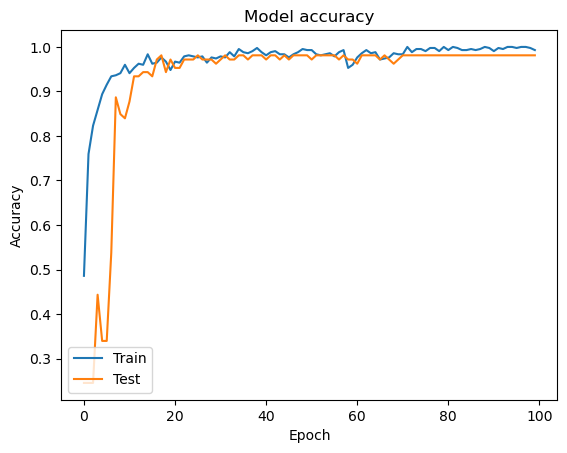

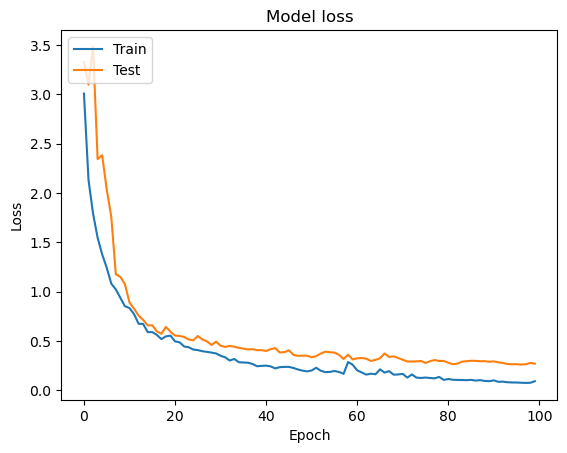

In [168]:
name = 'model'
model.save(name+'.h5')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower left')
plt.savefig(name+'_acc.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(name+'_loss.png')
plt.show()

In [169]:
y_pred_train = model.predict(X_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

14/14 [==============================] - 1s 24ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        71
           1       1.00      1.00      1.00        71
           2       1.00      1.00      1.00        71
           3       1.00      1.00      1.00        69
           4       1.00      1.00      1.00        71
           5       1.00      1.00      1.00        71

    accuracy                           1.00       424
   macro avg       1.00      1.00      1.00       424
weighted avg       1.00      1.00      1.00       424



In [170]:
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [171]:
import tensorflow as tf

# Assuming you have already obtained y_pred using the model.predict method
score = model.evaluate(X_test, y_test_hot)

print("Accuracy: ", score[1])
print("Loss: ", score[0])

print(confusion_matrix(np.argmax(y_test_hot, axis=1), np.argmax(model.predict(X_test), axis=1)))

4/4 [==============================] - 0s 28ms/step - loss: 0.2715 - accuracy: 0.9811
Accuracy:  0.9811320900917053
Loss:  0.2715400755405426
4/4 [==============================] - 0s 25ms/step
[[18  0  0  0  0  0]
 [ 0 17  0  0  1  0]
 [ 0  0 18  0  0  0]
 [ 0  0  0 17  0  0]
 [ 0  0  0  0 18  0]
 [ 0  0  0  1  0 16]]


4/4 [==============================] - 0s 27ms/step


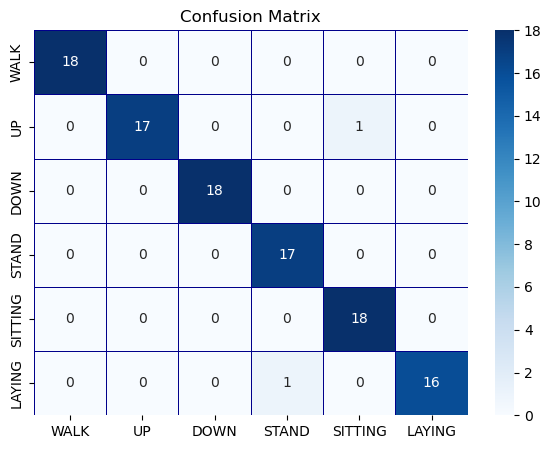

In [172]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_true_test contains your true labels for the test set
#y_true_test = np.argmax(y_test, axis=1)



y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Compute confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_test, y_pred)

# Create a DataFrame from the confusion matrix
confusion_matrix_df_test = pd.DataFrame(data=confusion_matrix_test,
                                        columns=['WALK', 'UP', 'DOWN', 'STAND', 'SITTING', 'LAYING'],
                                        index=['WALK', 'UP', 'DOWN', 'STAND', 'SITTING', 'LAYING'])

# Plot the heatmap for the test set
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix_df_test, annot=True, fmt='d', cmap="Blues", linecolor="DarkBlue", linewidths=0.55)
plt.title('Confusion Matrix')
plt.show()

4/4 [==============================] - 0s 25ms/step


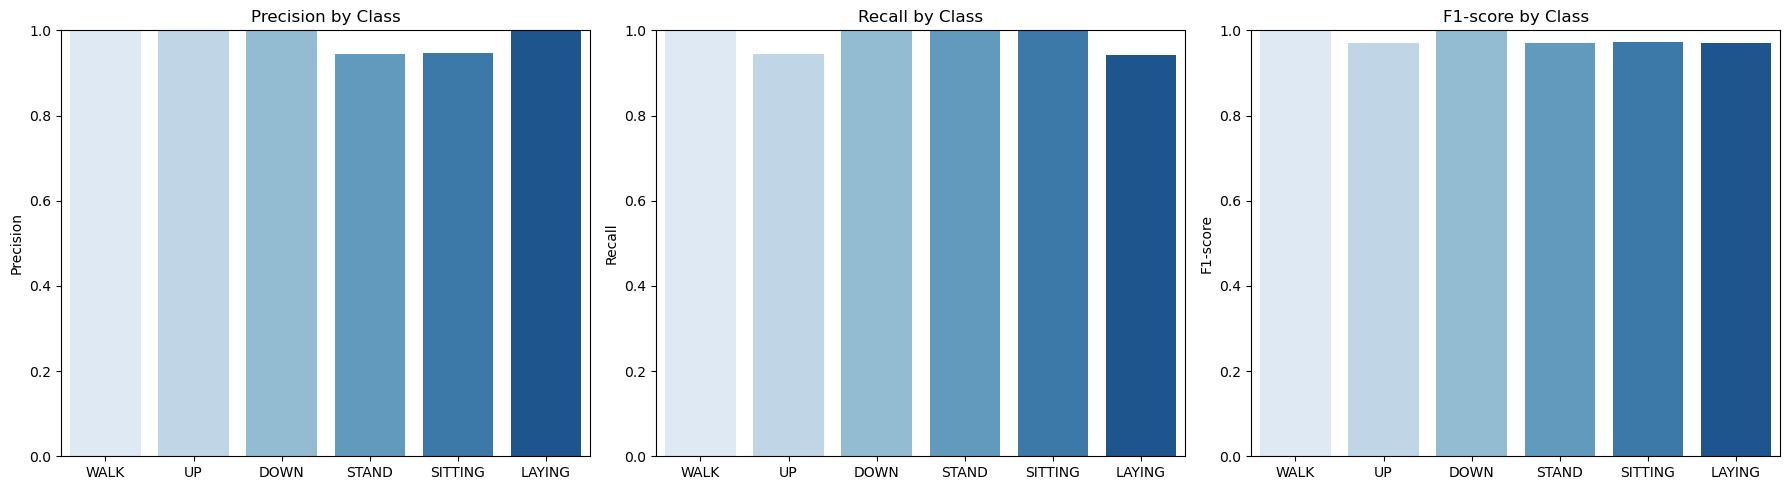

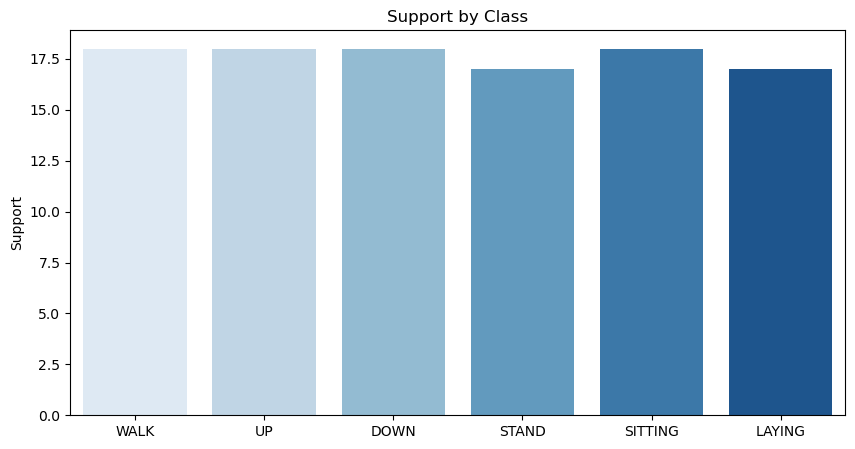

In [173]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Predict the labels for the test set
y_pred_prob = model.predict(X_test)
y_pred = y_pred_prob.argmax(axis=-1)

# Compute the classification report
class_report = classification_report(y_test, y_pred, target_names=['WALK', 'UP', 'DOWN', 'STAND', 'SITTING', 'LAYING'], output_dict=True)

# Convert the classification report to a DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Plot precision, recall, and F1-score
metrics = ['precision', 'recall', 'f1-score']
class_labels = ['WALK', 'UP', 'DOWN', 'STAND', 'SITTING', 'LAYING']

# Create a new color palette
color_palette = sns.color_palette("Blues")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics):
    sns.barplot(x=class_labels, y=class_report_df.loc[class_labels, metric], ax=axes[idx], palette=color_palette)
    axes[idx].set_title(f'{metric.capitalize()} by Class')
    axes[idx].set_ylabel(metric.capitalize())
    axes[idx].set_ylim(0, 1)

# Display the plots
plt.tight_layout()
plt.show()

# Plot support
plt.figure(figsize=(10, 5))
sns.barplot(x=class_labels, y=class_report_df.loc[class_labels, 'support'], palette=color_palette)
plt.title('Support by Class')
plt.ylabel('Support')
plt.show()


In [174]:
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adagrad, SGD, RMSprop
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Flatten, Dropout
from keras.regularizers import l2
from keras.layers import BatchNormalization

# Define a function to create the model
def create_model():
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), padding='same', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(6, activation='softmax'))
    
    return model

# List of optimizers to test
optimizers = {
    'Adam': Adam(learning_rate=0.001),
    'Adagrad': Adagrad(learning_rate=0.001),
    'SGD': SGD(learning_rate=0.001),
    'RMSprop': RMSprop(learning_rate=0.001)
}

# Dictionary to store training histories
histories = {}

# Train the model with each optimizer and store the history
for opt_name, opt in optimizers.items():
    print(f'Training with {opt_name} optimizer...')
    model = create_model()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train_hot, epochs=100, validation_data=(X_test, y_test_hot), verbose=1)
    histories[opt_name] = history


Training with Adam optimizer...
Epoch 1/100
14/14 [==============================] - 8s 155ms/step - loss: 2.6245 - accuracy: 0.4741 - val_loss: 2.6402 - val_accuracy: 0.2453
Epoch 2/100
14/14 [==============================] - 1s 87ms/step - loss: 1.7205 - accuracy: 0.7901 - val_loss: 2.4752 - val_accuracy: 0.3491
Epoch 3/100
14/14 [==============================] - 1s 82ms/step - loss: 1.4671 - accuracy: 0.8113 - val_loss: 2.1330 - val_accuracy: 0.3585
Epoch 4/100
14/14 [==============================] - 1s 82ms/step - loss: 1.2402 - accuracy: 0.8726 - val_loss: 2.0177 - val_accuracy: 0.3396
Epoch 5/100
14/14 [==============================] - 1s 81ms/step - loss: 1.1233 - accuracy: 0.8679 - val_loss: 1.4190 - val_accuracy: 0.7547
Epoch 6/100
14/14 [==============================] - 1s 80ms/step - loss: 0.9901 - accuracy: 0.9057 - val_loss: 1.1615 - val_accuracy: 0.8868
Epoch 7/100
14/14 [==============================] - 1s 83ms/step - loss: 0.9653 - accuracy: 0.8939 - val_loss: 1.1

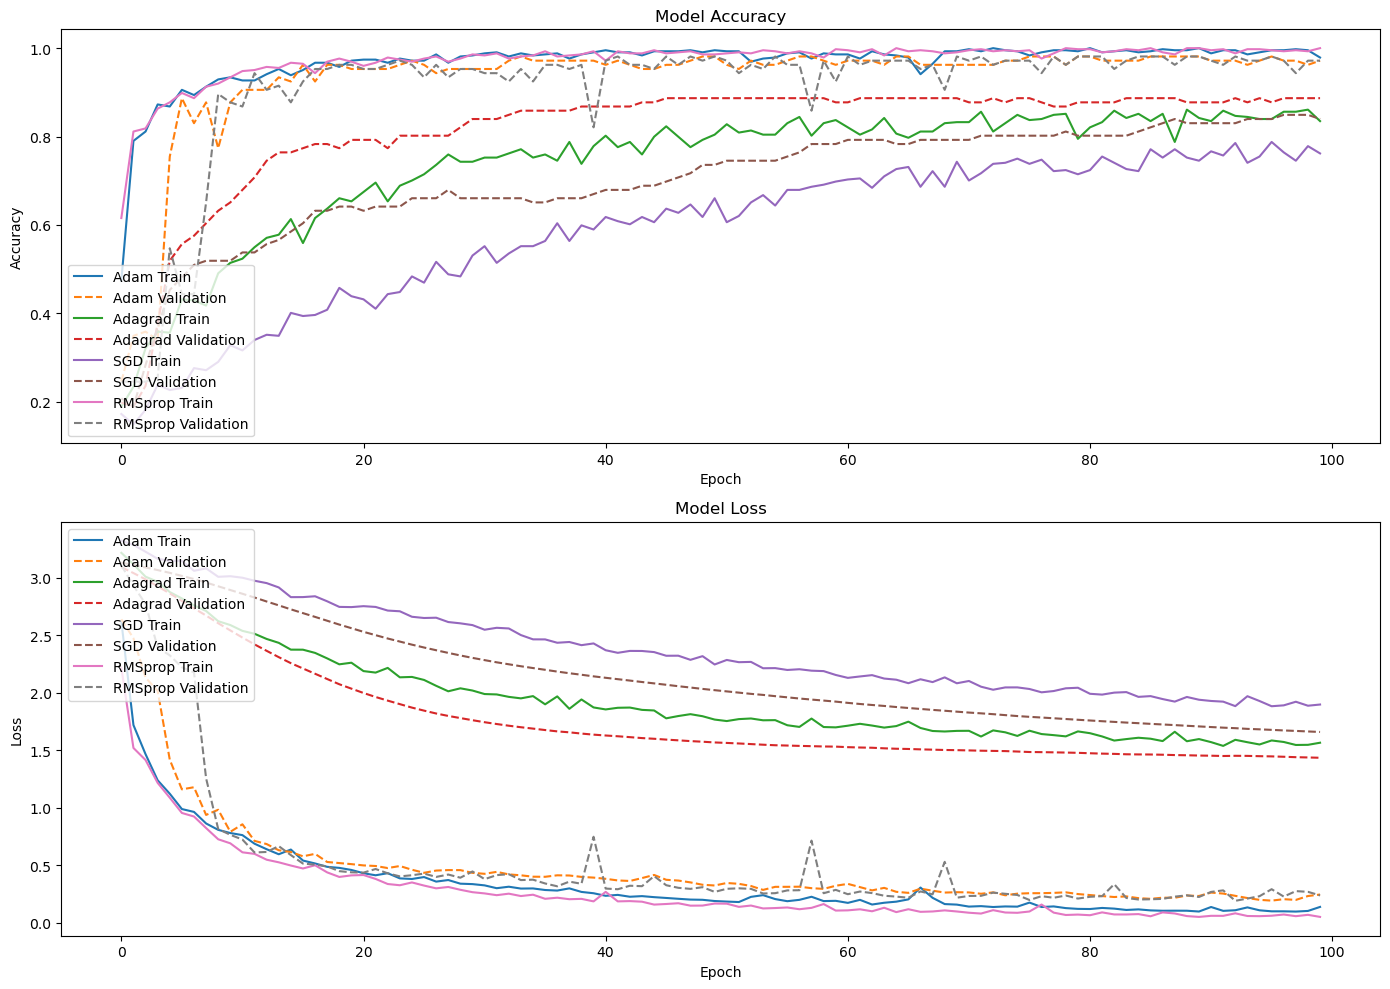

In [175]:
# Plot training and validation accuracy for each optimizer
plt.figure(figsize=(14, 10))

# Plot training accuracy
plt.subplot(2, 1, 1)
for opt_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{opt_name} Train')
    plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{opt_name} Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower left')

# Plot training and validation loss for each optimizer
plt.subplot(2, 1, 2)
for opt_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{opt_name} Train')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{opt_name} Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
